In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/mutation.py
%run ../Scripts/initMethods.py
%run ../Scripts/formulas.py
%run ../Scripts/entropy.py

In [2]:
params = { #parameters relevant for the equations
    "Nh":           10000,
    "N0":          100000,
    "M":                1, #Also L, total number of spacers
    "mu":               1, #mutation rate
    "gamma_shape":     20, 
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    100,
    "dx":                           1,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_var_n":               10,
    "num_threads":                  4,
}

In [3]:
n = init_guassian(params["N0"], sim_params, "n")
n_new = mutation(n, params, sim_params)
xdomain = sim_params["xdomain"]
dx = sim_params["dx"]
xspace = np.arange(-xdomain, xdomain, dx )

In [4]:
params["mu"] = mu = 10
params["gamma_shape"]= 0.5

In [5]:
def entropy_simulation(params, sim_params, t = 20, to_plot = False):
    n_old = init_guassian(params["N0"], sim_params, "n")
    n_new = mutation(n_old, params, sim_params)
    xdomain = sim_params["xdomain"]
    dx = sim_params["dx"]
    xspace = np.arange(-xdomain, xdomain, dx )
    
    entropy_change = np.zeros(t)
    entropy = np.zeros(t)
    entropy_guassian = np.zeros(t)

    N = params["N0"]
    if to_plot:
        plt.figure()

    for i in range(1, t):
        func = params["N0"]*guassian_diffusion(xspace, xspace, i, params, sim_params)
        flat_func = np.sum(func, axis = 0)

        n_new = mutation(n_old, params, sim_params)
        flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()

        if i%5 ==0 and to_plot:
            plt.plot(xspace, flat_func, alpha = 0.3)
            plt.plot(xspace, flat_n_new, label = f"time = {i}")

        entropy[i] = compute_entropy(n_new)
        entropy_change[i] = compute_entropy_change(n_new, n_old)
        entropy_guassian[i] = compute_entropy(func)
        n_old = n_new

    if to_plot:
        plt.legend()
        plt.show()
    return entropy_change, entropy, entropy_guassian

In [6]:
diff_consts = []
entropies = []
params["gamma_shape"] = 20
sim_params["xdomain"] = 1000

for mu in [0.01, 0.1 , 1]:
    params["mu"] = mu
    diff_const = calc_diff_const(params, sim_params)
    diff_consts.append(diff_const)
    entropy_change, entropy, entropy_normal = entropy_simulation(params, sim_params,to_plot = False)
    entropies.append([entropy, entropy_normal])

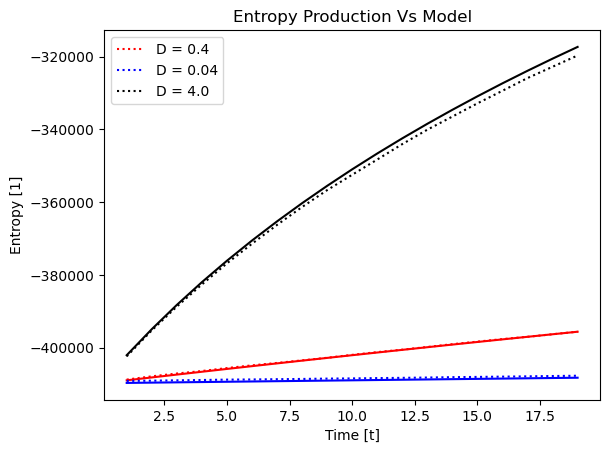

In [37]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]

var = sim_params["initial_var_n"]
colors = ['r', 'b', 'k']

for diff_const, entropy, color in zip(diff_consts, entropies, colors):

    plt.plot(t_range, entropy[0][1:], label = f"D = {diff_const}",linestyle = "dotted", color = color, linewidth = 1.5)
    # plt.plot(t_range, entropy[1][1:],linestyle = "--", linewidth = 1.5)
    plt.plot(t_range, compute_entropy_Gaussian(var**2, diff_const, t_range,N = N)-2800, color = color)
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.title("Entropy Vs Model")
plt.legend()
plt.show()

In [34]:
diff_consts = []
entropies = []
params["gamma_shape"] = 0.2
sim_params["xdomain"] = 1000

for mu in [0.1, 1 , 10]:
    params["mu"] = mu
    diff_const = calc_diff_const(params, sim_params)
    diff_consts.append(diff_const)
    entropy_change, entropy, entropy_normal = entropy_simulation(params, sim_params,to_plot = False)
    entropies.append([entropy, entropy_normal])

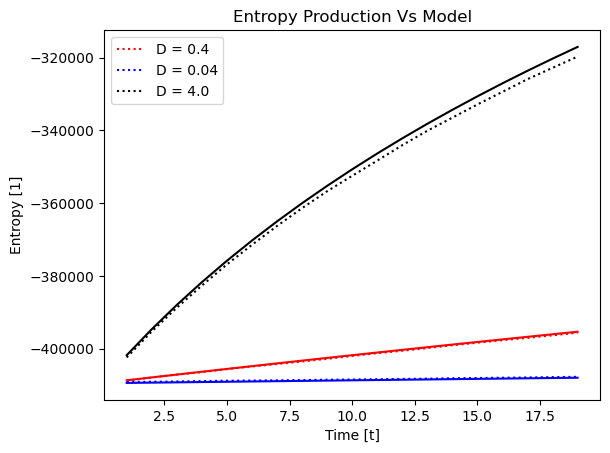

In [36]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]

var = sim_params["initial_var_n"]
colors = ['r', 'b', 'k']

for diff_const, entropy, color in zip(diff_consts, entropies, colors):

    plt.plot(t_range, entropy[0][1:], label = f"D = {diff_const}",linestyle = "dotted", color = color, linewidth = 1.5)
    # plt.plot(t_range, entropy[1][1:],linestyle = "--", linewidth = 1.5)
    plt.plot(t_range, compute_entropy_Gaussian(var**2, diff_const, t_range,N = N)-2500, color = color)
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.title("Entropy Vs Model")
plt.legend()
plt.show()

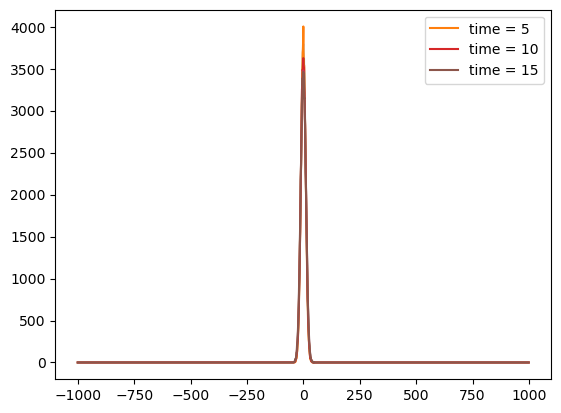

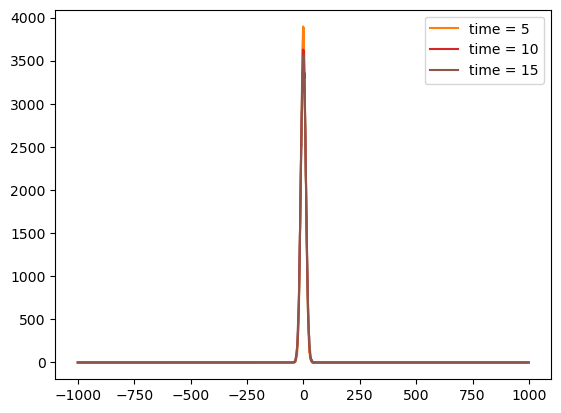

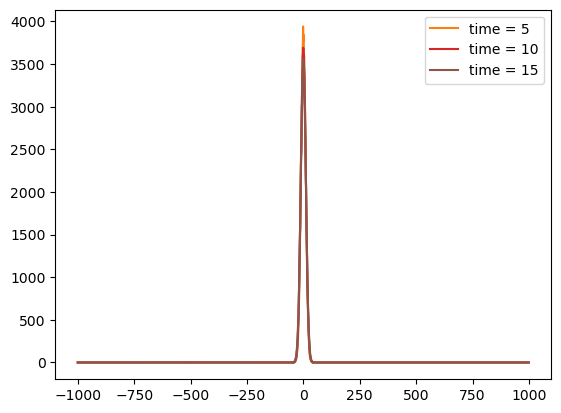

In [9]:
variances = []
entropies = []
params["mu"] = 1
params["gamma_shape"]=20

for var in [5, 10, 100]:
    params["init_var_n"] = var
    variances.append(var)
    entropies.append(entropy_simulation(params, sim_params, to_plot = True))

ValueError: x and y must have same first dimension, but have shapes (19,) and (2, 20)

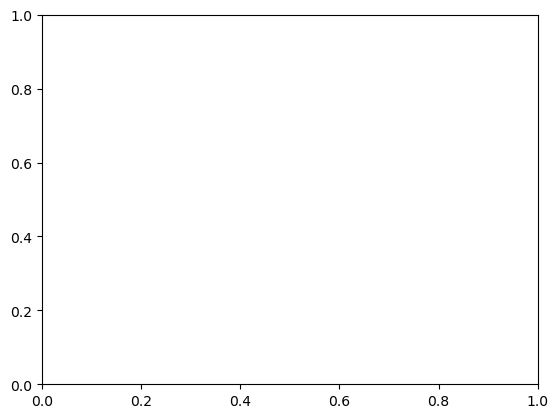

In [10]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]
diff_const = calc_diff_const(params, sim_params)

for var, entropy_change in zip(variances, entropies):
    plt.plot(t_range, entropy_change[1:], label = f"var = {var}",linestyle = "dotted", linewidth = 1.5)
    plt.plot(t_range, N*entropy_production_mutation(var**2, diff_const,t_range))
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.legend()
plt.show()

In [7]:
def compute_log_avg_Poisson(rate, n_samples):
    def Poisson_PDF(n, mu):
        return scipy.stats.poisson.pmf(n, mu)
    to_sample = np.arange(n_samples)
    to_average = np.log(to_sample+1)
    to_weight = Poisson_PDF(to_sample, rate)

    res = np.sum(to_average*to_weight)/np.sum(to_weight)
    return res
    

In [3]:
%run ../Scripts/entropy.py

In [4]:
n_samples = 100
single_fitness = 1
n_initial = 1

def sampling_Possion_process(n_samples, t, fit, n_initial = 1):
    rate = (1+fit*t)*n_initial
    return np.random.poisson(rate, n_samples)

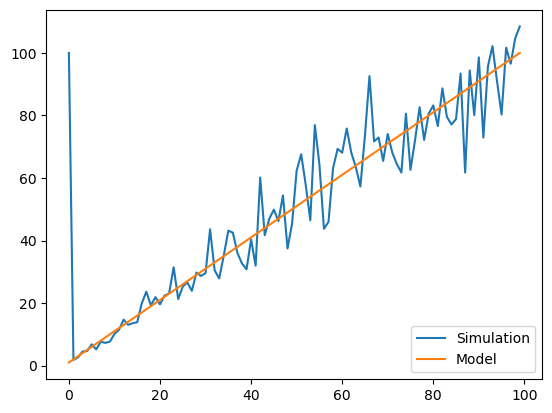

In [11]:
n_initial = np.ones(n_samples)
samples_time = [n_initial]
entropy_change_time = [0]
entropy_change_single_time = [0]
entropy_time = [compute_entropy(n_initial, dim =1)]
entropy_single_time = [compute_entropy(n_initial/np.sum(n_initial), dim =1)]
growth_time = [0]
population_size_time = [np.sum(n_initial)]
n_old = n_initial
t_range = [0]

for t in range(1, 100):
    n_new = sampling_Possion_process(n_samples, t, single_fitness)
    entropy_change = compute_entropy_change(n_new, n_old, dim = 1)
    size = np.sum(n_new)
    entropy = compute_entropy(n_new, dim =1)
    entropy_single = compute_entropy(n_new/np.sum(n_new), dim =1)
    entropy_change_single = compute_entropy_change(n_new/np.sum(n_new), n_old/np.sum(n_old), dim =1)
    change_growth = np.sum(n_new) - np.sum(n_old)
    
    entropy_change_time.append(entropy_change)
    entropy_change_single_time.append(entropy_change_single)
    entropy_time.append(entropy)
    entropy_single_time.append(entropy_single)
    samples_time.append(n_new)
    growth_time.append(change_growth)
    population_size_time.append(np.var(n_new))

    n_old = n_new
    t_range.append(t)
t_range = np.array(t_range).squeeze()

plt.figure()
plt.plot(t_range, population_size_time, label = "Simulation")
plt.plot(t_range, (1+single_fitness*t_range), label = "Model")
plt.legend()

In [6]:
n_initial = np.ones(n_samples)
samples_time = [n_initial]
entropy_change_time = [0]
entropy_change_single_time = [0]
entropy_time = [compute_entropy(n_initial, dim =1)]
entropy_single_time = [compute_entropy(n_initial/np.sum(n_initial), dim =1)]
growth_time = [0]
population_size_time = [np.sum(n_initial)]
n_old = n_initial
t_range = [0]
fitness_entropy = []

for fitness in fitness_list:
    for t in range(1, 100):
        n_new = sampling_Possion_process(n_samples, t, single_fitness)
        entropy_change = compute_entropy_change(n_new, n_old, dim = 1)
        size = np.sum(n_new)
        entropy = compute_entropy(n_new, dim =1)
        entropy_single = compute_entropy(n_new/np.sum(n_new), dim =1)
        entropy_change_single = compute_entropy_change(n_new/np.sum(n_new), n_old/np.sum(n_old), dim =1)
        change_growth = np.sum(n_new) - np.sum(n_old)
        
        entropy_change_time.append(entropy_change)
        entropy_change_single_time.append(entropy_change_single)
        entropy_time.append(entropy)
        entropy_single_time.append(entropy_single)
        samples_time.append(n_new)
        growth_time.append(change_growth)
        population_size_time.append(np.var(n_new))

        n_old = n_new
        t_range.append(t)
    
    fitness_entropy.append(entropy_single[1:])
t_range = np.array(t_range).squeeze()

plt.figure()
for fit in fitness_list:
    plt.plot(t_range, population_size_time, label = "Simulation")
    plt.plot(t_range, (1+single_fitness*t_range), label = "Model")
plt.legend()

NameError: name 'fitness_list' is not defined

In [13]:
entropy_N_single = []
entropy_N_population = []
entropy_N = []
for i, t in enumerate(t_range):
    R1 = population_size_time[i]*entropy_single_time[i]
    R2 = -1*population_size_time[i]*np.log(population_size_time[i])
    entropy_N_single.append(R1)
    entropy_N_population.append(R2)
    entropy_N.append(R1+R2)

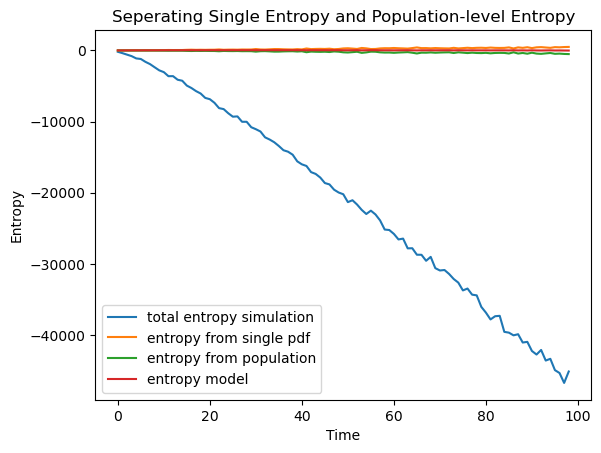

In [14]:
plt.figure()
plt.plot(entropy_time[1:], label = "total entropy simulation")
plt.plot(entropy_N_single[1:], label = "entropy from single pdf")
plt.plot(entropy_N_population[1:], label = "entropy from population")
# plt.plot(dumb_entropy[1:], label = "dumb entropy")
plt.plot(entropy_N[1:], label = "entropy model")
plt.title("Seperating Single Entropy and Population-level Entropy")
plt.ylabel("Entropy")
plt.xlabel("Time")
plt.legend()

In [208]:
def entropy_production_growth(fit, t, n_initial):
    rate = (1+fit*t)*n_initial
    log_avg = compute_log_avg_Poisson(rate, 100)
    S1 = -n_initial*fit*np.log(rate) - n_initial*fit*log_avg
    return S1

entropy_model = np.zeros_like(t_range)
for i, t in enumerate(t_range):
    N = (1+single_fitness*t)*np.sum(n_initial)
    S = entropy_single_time[i]
    Nt = single_fitness
    R1 = N*entropy_production_growth(single_fitness, t, 1)
    entropy_model[i] = -Nt*np.log(N) - Nt - R1 + Nt*S

In [220]:
entropy_single_model = entropy_production_growth(single_fitness, t_range, 1)

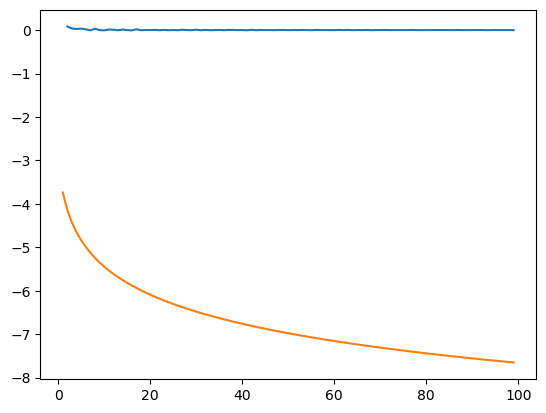

In [210]:
plt.figure()
plt.plot(t_range[2:], entropy_change_single_time[2:])
plt.plot(t_range[1:], entropy_production_growth(single_fitness, t_range, 1)[1:])

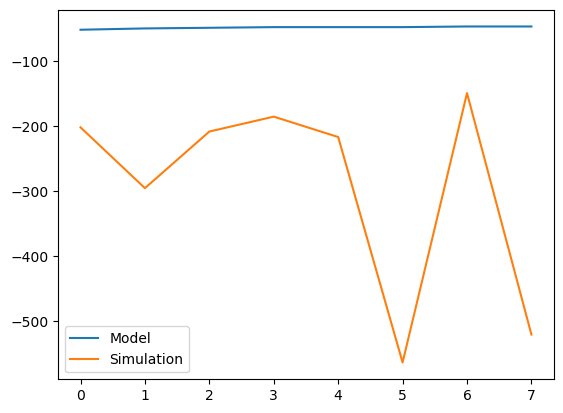

In [204]:
plt.figure()
plt.plot(-1*entropy_model[2:10], label = "Model")
plt.plot( entropy_change_time[2:10], label = "Simulation")
plt.legend()

Text(0, 0.5, 'log Average')

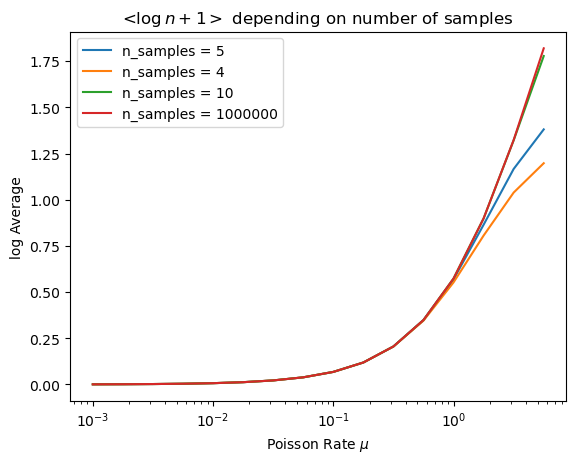

In [50]:
log_avgs1 = []
array = [5, 4, 10, 10**6]
rates = 10**np.arange(-3, 1, 0.25)

for rate in rates:
    log_avgs1.append(compute_log_avg_Poisson(rate, array[0]))

log_avgs2 = []
for rate in rates:
    log_avgs2.append(compute_log_avg_Poisson(rate, array[1]))

log_avgs3 = []
for rate in rates:
    log_avgs3.append(compute_log_avg_Poisson(rate, array[2]))

log_avgs4 = []
for rate in rates:
    log_avgs4.append(compute_log_avg_Poisson(rate, array[3]))

plt.figure
plt.plot(rates, log_avgs1, label = f"n_samples = {array[0]}")
plt.plot(rates, log_avgs2, label = f"n_samples = {array[1]}")
plt.plot(rates, log_avgs3, label = f"n_samples = {array[2]}")
plt.plot(rates, log_avgs4, label = f"n_samples = {array[3]}")
plt.legend()
plt.xscale("log")
plt.title(r"<$\log{n+1}>$ depending on number of samples")
plt.xlabel(r"Poisson Rate $\mu$")
plt.ylabel("log Average")